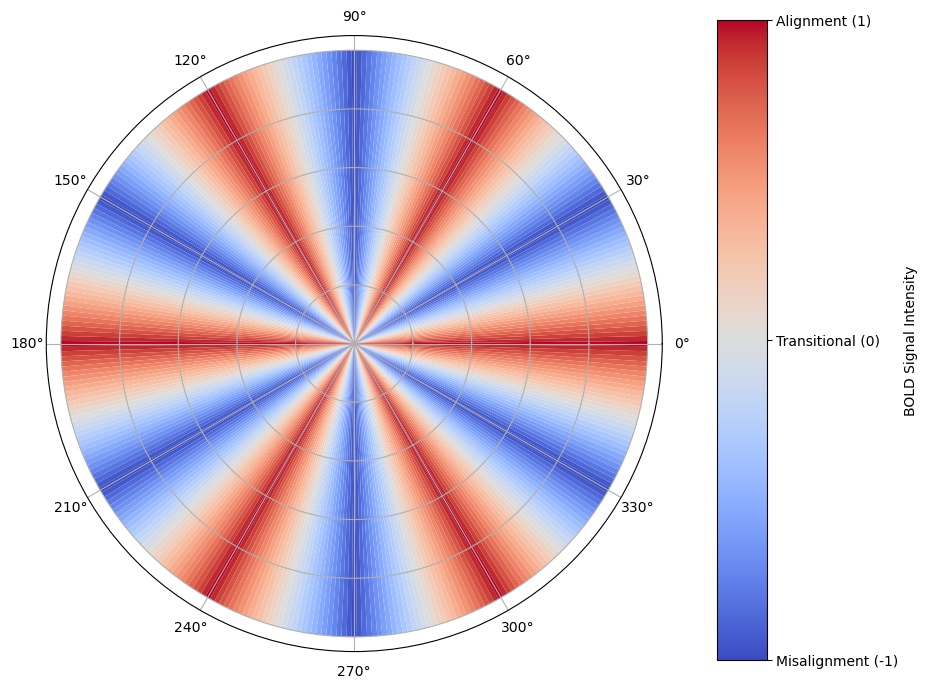

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Define the number of points in the circle
num_points = 360

# Generate angles from 0 to 2*pi radians
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

# Initialize intensity array
intensities = np.zeros(num_points)

# Assign intensities based on angle within each 30-degree segment
for i, angle in enumerate(angles):
    # Each 30-degree segment corresponds to pi/6 radians
    segment = int(angle / (np.pi / 6))
    normalized_angle = (angle % (np.pi / 6)) / (np.pi / 6)
    
    # Alternate intensity from 1 to -1 in every 30-degree segment
    if segment % 2 == 0:
        # From 1 (alignment) to 0 (transitional)
        intensity = 1 - 2 * normalized_angle
    else:
        # From 0 (transitional) to -1 (misalignment)
        intensity = -1 + 2 * normalized_angle
    
    intensities[i] = intensity

# Create a figure and a polar subplot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Plot bars with colors based on mapped intensities
bars = ax.bar(angles, np.ones(num_points), width=2 * np.pi / num_points, 
              color=plt.cm.coolwarm((intensities + 1) / 2), edgecolor='none')

# Adjust subplot to make room for the colorbar
fig.subplots_adjust(right=0.75)

# Set up the colorbar to the right of the plot
cax = fig.add_axes([0.8, 0.1, 0.05, 0.8])  # [left, bottom, width, height]

# Create a ScalarMappable for the colorbar with normalization from -1 to 1
norm = Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array(intensities)  # Essential for the colorbar to map correctly

# Add the colorbar to the specified axes
cbar = fig.colorbar(sm, cax=cax, ticks=[-1, 0, 1], orientation='vertical')
cbar.ax.set_yticklabels(['Misalignment (-1)', 'Transitional (0)', 'Alignment (1)'])
cbar.set_label('BOLD Signal Intensity')

# Customize the polar plot
ax.set_yticklabels([])  # Remove radial labels
ax.set_xticks(np.deg2rad([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]))  # Major ticks every 30 degrees
ax.set_xticklabels(['0°', '30°', '60°', '90°', '120°', '150°', '180°', '210°', '240°', '270°', '300°', '330°'])
ax.grid(True)

plt.show()

In [3]:
import numpy as np
import pandas as pd
import os
import nibabel as nib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D,
    MaxPooling3D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Loading Functions ---

def get_run_prefixes():
    """Generate run prefixes for s05 and s14 runs."""
    s05 = [f"s05_run{str(i).zfill(3)}" for i in range(1, 13)]  # s05_run001 to s05_run012
    s14 = [f"s14_run{str(i).zfill(3)}" for i in range(2, 13)]  # s14_run002 to s14_run012
    return s05 + s14

def match_files(input_dir, output_dir, prefixes):
    """Match NIfTI files with their corresponding CSV label files."""
    matched = []
    for prefix in prefixes:
        nifti_path = os.path.join(input_dir, f"{prefix}.nii")
        csv_path = os.path.join(output_dir, f"{prefix}_orientations.csv")
        if os.path.isfile(nifti_path) and os.path.isfile(csv_path):
            matched.append((nifti_path, csv_path))
            print(f"Matched: {nifti_path} <--> {csv_path}")
        else:
            print(f"Warning: Missing file for prefix '{prefix}'")
    return matched

def load_data(input_dir, output_dir, prefixes, required_columns):
    """Load data and extract specified 3D volumes with corresponding labels."""
    X = []  # List to store 3D volumes
    y = []  # List to store orientation labels

    for nifti_path, csv_path in match_files(input_dir, output_dir, prefixes):
        try:
            # Load NIfTI data
            nii_img = nib.load(nifti_path)
            data = nii_img.get_fdata()
            print(f"Loaded NIfTI: {nifti_path} with shape {data.shape}")

            # Load CSV labels
            labels_df = pd.read_csv(csv_path)
            print(f"Loaded CSV: {csv_path} with {len(labels_df)} entries")

            # Validate CSV columns
            if not required_columns.issubset(labels_df.columns):
                print(f"Error: Missing columns in {csv_path}. Required columns: {required_columns}")
                continue

            # Extract 'Volume Index' and 'Orientation'
            volume_indices = labels_df['Volume Index'].values
            orientations = labels_df['Orientation'].values

            # Validate volume indices
            max_index = data.shape[3] - 1
            if np.any(volume_indices > max_index) or np.any(volume_indices < 0):
                print(f"Error: Volume indices in {csv_path} are out of bounds for {nifti_path}")
                continue

            # Extract specified volumes using numpy.take for efficiency
            extracted_volumes = np.take(data, volume_indices, axis=3)  # Shape: (96, 96, 20, num_samples)
            print(f"Extracted volumes shape: {extracted_volumes.shape}")

            # Transpose to (num_samples, 96, 96, 20)
            extracted_volumes = np.transpose(extracted_volumes, (3, 0, 1, 2))  # Shape: (num_samples, 96, 96, 20)

            # Add channel dimension to make it (num_samples, 96, 96, 20, 1)
            extracted_volumes = extracted_volumes[..., np.newaxis]
            print(f"Reshaped volumes for CNN: {extracted_volumes.shape}")

            # Append to X and y
            X.append(extracted_volumes)
            y.append(orientations)

            print(f"Successfully extracted and reshaped {len(orientations)} samples from {nifti_path} and {csv_path}\n")
        except Exception as e:
            print(f"Error processing {nifti_path} and {csv_path}: {e}")
            continue

    # Concatenate all matched samples (X input with y "Orientation label")
    if X:
        X = np.concatenate(X, axis=0)  # Shape: (total_samples, 96, 96, 20, 1)
        y = np.concatenate(y, axis=0)  # Shape: (total_samples,)
    else:
        X = np.array([]).reshape(0, 96, 96, 20, 1)
        y = np.array([])
        print("No data was loaded. Please check your input directories and file formats.")

    print(f"Final X shape: {X.shape}")
    print(f"Final y shape: {y.shape}")

    return X, y

# --- Data Preprocessing ---

# Step 1: Load Data
input_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT'  
output_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation'   
prefixes = get_run_prefixes()
required_columns = {'Volume Index', 'Orientation'}
X, y = load_data(input_dir, output_dir, prefixes, required_columns)

# Check if data is loaded
if X.size == 0 or y.size == 0:
    raise ValueError("No data loaded. Please check your input directories and file formats.")

print(f"Data loaded successfully. X shape: {X.shape}, y shape: {y.shape}")

# Step 2: Normalize X
# Flatten the spatial and temporal dimensions for scaling
num_samples = X.shape[0]
X_reshaped = X.reshape(num_samples, -1)  # Shape: (num_samples, 96*96*20)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform
X_normalized = scaler.fit_transform(X_reshaped)

# Reshape back to original shape
X_normalized = X_normalized.reshape(num_samples, 96, 96, 20, 1)

print(f"X normalized. New shape: {X_normalized.shape}")

# Step 3: Encode y using sine and cosine
# Convert degrees to radians
y_rad = np.deg2rad(y)

# Compute sine and cosine components
y_sin = np.sin(y_rad)
y_cos = np.cos(y_rad)

# Combine into a single array
y_encoded = np.stack((y_sin, y_cos), axis=1)  # Shape: (num_samples, 2)

print(f"y encoded. Shape: {y_encoded.shape}")

# --- Dataset Splitting ---

# Split the data into training and testing sets
# Let's use 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_encoded, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

# --- Building the CNN Model ---

def build_cnn_model(input_shape):
    model = Sequential()

    # First Conv3D layer with 'same' padding
    model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second Conv3D layer with 'same' padding
    model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third Conv3D layer with 'same' padding
    model.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='linear'))  # Output layer for sine and cosine

    return model

# Build the model
input_shape = X_train.shape[1:]  # (96, 96, 20, 1)
model = build_cnn_model(input_shape)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mean_squared_error',  
    metrics=['mae']
)

# Display the model architecture
model.summary()

# --- Training the Model ---

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# --- Evaluating the Model ---

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on the test set
y_pred = model.predict(X_test)

# Convert sine and cosine back to angles in degrees
y_pred_angles = np.rad2deg(np.arctan2(y_pred[:, 0], y_pred[:, 1]))
y_pred_angles = np.mod(y_pred_angles, 360)  # Ensure angles are within [0, 360)

# Convert actual encoded y back to angles
y_test_angles = np.rad2deg(np.arctan2(y_test[:, 0], y_test[:, 1]))
y_test_angles = np.mod(y_test_angles, 360)

# Function to compute angular error
def angular_error(true_angles, pred_angles):
    """Compute minimal angular difference in degrees."""
    error = np.abs(true_angles - pred_angles) % 360
    error = np.where(error > 180, 360 - error, error)
    return error

# Compute angular errors
errors = angular_error(y_test_angles, y_pred_angles)
mean_error = np.mean(errors)
median_error = np.median(errors)

print(f"Mean Angular Error: {mean_error:.2f} degrees")
print(f"Median Angular Error: {median_error:.2f} degrees")

# --- Visualization Functions ---

def visualize_polar_results(true_angles, pred_angles, b_old_intensity):
    """
    Visualize actual and predicted orientations on a polar plot.
    
    Parameters:
    - true_angles: Array of true orientation angles in degrees.
    - pred_angles: Array of predicted orientation angles in degrees.
    - b_old_intensity: Array of BOLD signal intensities or relevant metric.
    """
    # Convert angles to radians
    true_rad = np.deg2rad(true_angles)
    pred_rad = np.deg2rad(pred_angles)
    
    # Create a figure and polar subplot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
    
    # Scatter plot for true orientations
    scatter_true = ax.scatter(true_rad, np.ones_like(true_rad), c=b_old_intensity, cmap='coolwarm', alpha=0.6, label='Actual')
    
    # Scatter plot for predicted orientations
    scatter_pred = ax.scatter(pred_rad, np.ones_like(pred_rad)*0.95, c=b_old_intensity, cmap='coolwarm', alpha=0.6, label='Predicted', marker='x')
    
    # Add a colorbar
    cbar = plt.colorbar(scatter_true, ax=ax, orientation='vertical', pad=0.1)
    cbar.set_label('BOLD Signal Intensity')
    
    # Customize the polar plot
    ax.set_title('Actual vs. Predicted Orientations', fontsize=16)
    ax.legend(loc='upper right')
    
    # Remove radial labels
    ax.set_yticklabels([])
    
    # Set major ticks every 30 degrees
    major_ticks = np.deg2rad([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330])
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(['0°', '30°', '60°', '90°', '120°', '150°', '180°', '210°', '240°', '270°', '300°', '330°'])
    
    ax.grid(True)
    
    plt.show()

def plot_error_distribution(errors):
    """Plot the distribution of angular errors."""
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=30, kde=True, color='skyblue')
    plt.title('Distribution of Angular Prediction Errors')
    plt.xlabel('Angular Error (degrees)')
    plt.ylabel('Frequency')
    plt.show()

# --- Visualization ---

# Assuming some measure of BOLD intensity, e.g., mean signal across all voxels
bold_intensity_test = X_test.mean(axis=(1,2,3,4))  # Shape: (num_test_samples,)

visualize_polar_results(y_test_angles, y_pred_angles, bold_intensity_test)
plot_error_distribution(errors)


Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run001.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run001_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run002.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run002_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run003.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run003_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run004.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run004_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run005.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run005_orientations.csv
Matched: /Users/danielledowe/Deskto

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 96, 96, 20, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 20, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 48, 48, 10, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 48, 48, 10, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 10, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 24, 24, 5, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 24, 24, 5, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 5, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 12, 12, 2, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,716,418 (37.07 MB)

 Trainable params: 9,715,970 (37.06 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1414s 18s/step - loss: 19.8964 - mae: 2.7597 - val_loss: 0.5002 - val_mae: 0.6323
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1446s 18s/step - loss: 0.5038 - mae: 0.6280 - val_loss: 0.5000 - val_mae: 0.6321
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1763s 23s/step - loss: 0.5007 - mae: 0.6271 - val_loss: 0.5002 - val_mae: 0.6319
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1081s 14s/step - loss: 0.5001 - mae: 0.6279 - val_loss: 0.5000 - val_mae: 0.6316
Epoch 5/10
44/78 ━━━━━━━━━━━━━━━━━━━━ 6:00 11s/step - loss: 0.4995 - mae: 0.6287

Try SVM?

### Preprocess

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import os

# Paths
nifti_file_path = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run001.nii'
labels_file_path = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run001_orientations.csv'

# Load the NIfTI file
print("Loading NIfTI file...")
img = nib.load(nifti_file_path)
data = img.get_fdata()
print(f"NIfTI data shape: {data.shape}")  # Expected: (96, 96, 20, timepoints)

# Identify non-zero voxels across all timepoints
print("\nIdentifying non-zero voxels across x,y,z...")
non_zero_voxels = np.any(data != 0, axis=3)  # 3D boolean mask
non_zero_coords = np.argwhere(non_zero_voxels)  # Coordinates of non-zero voxels
num_non_zero_voxels = len(non_zero_coords)
print(f"Total non-zero voxels: {num_non_zero_voxels}")


Loading NIfTI file...
NIfTI data shape: (96, 96, 20, 328)

Identifying non-zero voxels across x,y,z...
Total non-zero voxels: 96


In [2]:
# Extract BOLD time series for non-zero voxels
print("\nExtracting BOLD time series for non-zero voxels...")
bold_signals = data[non_zero_voxels]  # Shape: (num_non_zero_voxels, timepoints)
print(f"BOLD signals shape: {bold_signals.shape}")  # Expected: (num_non_zero_voxels, timepoints)



Extracting BOLD time series for non-zero voxels...
BOLD signals shape: (96, 328)


In [6]:
import os
import glob
import pandas as pd
import nibabel as nib
import numpy as np

def get_run_prefixes():
    """Generate run prefixes for s05 and s14 runs."""
    s05 = [f"s05_run{str(i).zfill(3)}" for i in range(1, 13)]  # s05_run001 to s05_run012
    s14 = [f"s14_run{str(i).zfill(3)}" for i in range(2, 13)]  # s14_run002 to s14_run012
    return s05 + s14

def match_files(input_dir, output_dir, prefixes):
    """Match NIfTI files with their corresponding CSV label files."""
    matched = []
    for prefix in prefixes:
        nifti_path = os.path.join(input_dir, f"{prefix}.nii")
        csv_path = os.path.join(output_dir, f"{prefix}_orientations.csv")
        if os.path.isfile(nifti_path) and os.path.isfile(csv_path):
            matched.append((nifti_path, csv_path))
            print(f"Matched: {nifti_path} <--> {csv_path}")
        else:
            print(f"Warning: Missing file for prefix '{prefix}'")
    return matched

def load_and_validate(nifti_path, csv_path, required_columns):
    """Load NIfTI and CSV files, validate, and extract data."""
    try:
        # Load NIfTI data
        nii_img = nib.load(nifti_path)
        data = nii_img.get_fdata()
        print(f"Loaded NIfTI: {nifti_path} with shape {data.shape}")
        
        # Load CSV labels
        labels_df = pd.read_csv(csv_path)
        print(f"Loaded CSV: {csv_path} with {len(labels_df)} entries")
        
        # Validate CSV columns
        if not required_columns.issubset(labels_df.columns):
            print(f"Error: Missing columns in {csv_path}. Required columns: {required_columns}")
            return None, None
        
        # Validate volume count
        if data.shape[3] != len(labels_df):
            print(f"Error: Volume mismatch in {nifti_path} and {csv_path}")
            return None, None
        
        # Reshape BOLD signals: (voxels, volumes) -> (volumes, voxels)
        bold_signals = data.reshape(-1, data.shape[3]).T
        labels = labels_df['Orientation'].values
        return bold_signals, labels
    except Exception as e:
        print(f"Error processing {nifti_path} and {csv_path}: {e}")
        return None, None

def aggregate_data(matched_files, required_columns):
    """Aggregate BOLD signals and labels from all matched files."""
    all_bold = []
    all_labels = []
    for nifti, csv in matched_files:
        bold, labels = load_and_validate(nifti, csv, required_columns)
        if bold is not None and labels is not None:
            all_bold.append(bold)
            all_labels.append(labels)
            print(f"Successfully aggregated data from {nifti} and {csv}\n")
    if all_bold and all_labels:
        X = np.vstack(all_bold)  # Shape: (total_volumes, num_voxels)
        y = np.concatenate(all_labels)  # Shape: (total_volumes,)
        print(f"Aggregated BOLD signals shape: {X.shape}")
        print(f"Aggregated labels shape: {y.shape}")
        return X, y
    else:
        print("No data was aggregated. Please check file matches and data integrity.")
        return None, None

def main():
    # Define directories
    input_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT'
    output_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation'
    
    # Define required CSV columns
    required_columns = {'Volume Index', 'Volume Start Time (s)', 'Label Time (s)', 'Orientation'}
    
    # Get run prefixes
    prefixes = get_run_prefixes()
    
    # Match files
    print("Matching NIfTI and CSV files...")
    matched_files = match_files(input_dir, output_dir, prefixes)
    print(f"\nTotal matched file pairs: {len(matched_files)}\n")
    
    # Aggregate data
    X, y = aggregate_data(matched_files, required_columns)
    
    if X is not None and y is not None:
        # Example: Split into training and testing sets
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        print(f"Training set size: {X_train.shape}, Training labels size: {y_train.shape}")
        print(f"Testing set size: {X_test.shape}, Testing labels size: {y_test.shape}")
    else:
        print("Data aggregation failed. Exiting.")

if __name__ == "__main__":
    main()


Matching NIfTI and CSV files...
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run001.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run001_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run002.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run002_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run003.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run003_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run004.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run004_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run005.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run005_orientations.csv
Mat

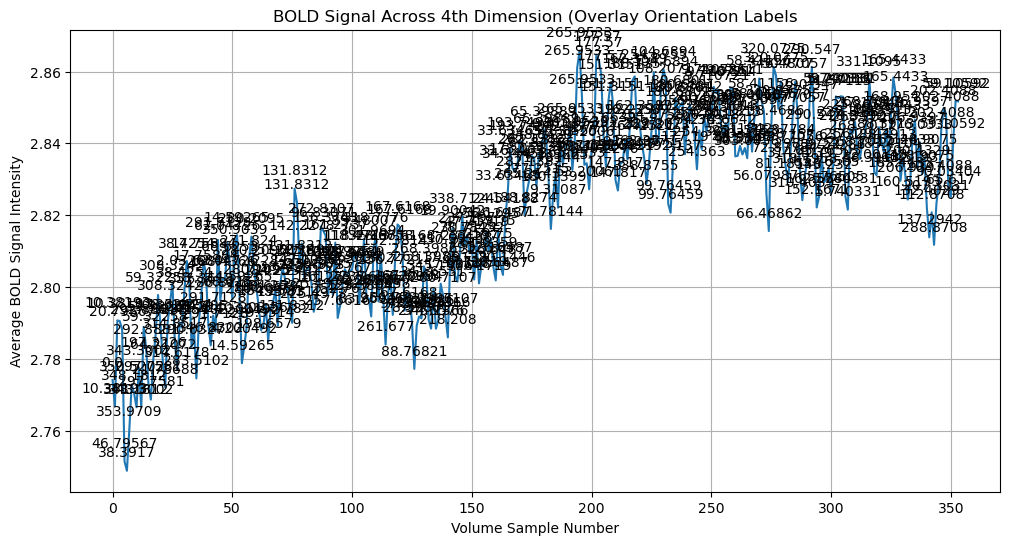

In [15]:
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import numpy as np

# Load the NIfTI file
nii_path = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s14_run002.nii'
nii_img = nib.load(nii_path)
data = nii_img.get_fdata()  # Get the data from the NIfTI image

# Load the corresponding CSV for orientation labels
csv_path = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s14_run002_orientations.csv'
labels_df = pd.read_csv(csv_path)
orientations = labels_df['Orientation'].values  # Assuming the column name is 'Orientation'

# Calculate the average BOLD signal across all voxels at each time point
# This simplifies the plot and avoids having to select a single voxel
bold_signals = data.reshape(-1, data.shape[3]).mean(axis=0)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
time_points = np.arange(len(bold_signals))
ax.plot(time_points, bold_signals, label='Average BOLD Signal')

# Overlay orientation labels
for i, label in enumerate(orientations):
    ax.annotate(str(label), (time_points[i], bold_signals[i]), textcoords="offset points", xytext=(0,10), ha='center')

ax.set_xlabel('Volume Sample Number')
ax.set_ylabel('Average BOLD Signal Intensity')
ax.set_title('BOLD Signal Across 4th Dimension (Overlay Orientation Labels')
plt.grid(True)
plt.show()


### 3D CNN (Regression-MSE, Predict orrientation labels)

In [1]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D,
    MaxPooling3D,
    Flatten,
    Dense,
    BatchNormalization,
    Dropout,
)
from tensorflow.keras.optimizers import Adam

def get_run_prefixes():
    """Generate run prefixes for s05 and s14 runs."""
    s05 = [f"s05_run{str(i).zfill(3)}" for i in range(1, 13)]  # s05_run001 to s05_run012
    s14 = [f"s14_run{str(i).zfill(3)}" for i in range(2, 13)]  # s14_run002 to s14_run012
    return s05 + s14

def match_files(input_dir, output_dir, prefixes):
    """Match NIfTI files with their corresponding CSV label files."""
    matched = []
    for prefix in prefixes:
        nifti_path = os.path.join(input_dir, f"{prefix}.nii")
        csv_path = os.path.join(output_dir, f"{prefix}_orientations.csv")
        if os.path.isfile(nifti_path) and os.path.isfile(csv_path):
            matched.append((nifti_path, csv_path))
            print(f"Matched: {nifti_path} <--> {csv_path}")
        else:
            print(f"Warning: Missing file for prefix '{prefix}'")
    return matched

def load_data(input_dir, output_dir, prefixes, required_columns):
    """Load data and extract 3D volumes with corresponding labels."""
    X = []  # List to store 3D volumes
    y = []  # List to store orientation labels
    
    for nifti_path, csv_path in match_files(input_dir, output_dir, prefixes):
        try:
            # Load NIfTI data
            nii_img = nib.load(nifti_path)
            data = nii_img.get_fdata()
            print(f"Loaded NIfTI: {nifti_path} with shape {data.shape}")
            
            # Load CSV labels
            labels_df = pd.read_csv(csv_path)
            print(f"Loaded CSV: {csv_path} with {len(labels_df)} entries")
            
            # Validate CSV columns
            if not required_columns.issubset(labels_df.columns):
                print(f"Error: Missing columns in {csv_path}. Required columns: {required_columns}")
                continue
            
            # Validate volume count
            if data.shape[3] != len(labels_df):
                print(f"Error: Volume mismatch in {nifti_path} and {csv_path}")
                continue
            
            # Normalize the BOLD signals 
            data = (data - np.mean(data)) / np.std(data)
            
            # Extract individual volumes and their labels
            for i in range(data.shape[3]):
                volume = data[:, :, :, i]  # 3D volume at time point i
                volume = np.expand_dims(volume, axis=-1)  # Add channel dimension
                X.append(volume)
                y.append(labels_df['Orientation'].values[i])
            
            print(f"Successfully processed {nifti_path} and {csv_path}\n")
        except Exception as e:
            print(f"Error processing {nifti_path} and {csv_path}: {e}")
            continue
    
    X = np.array(X)  # Shape: (total_samples, x_dim, y_dim, z_dim, channels)
    y = np.array(y)  # Shape: (total_samples,)
    return X, y


In [2]:
# 3D CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    
    # Convolutional layers with 'same' padding
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))  # Output layer for regression
    
    return model

# Create Data Generators for Efficient Data Handling
class DataGenerator(Sequence):
    """Generates data for Keras."""
    def __init__(self, X_list, y_list, batch_size=8, shuffle=True):
        self.X = X_list
        self.y = y_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        self.on_epoch_end()
    
    def __len__(self):
        """Denotes the number of batches per epoch."""
        return int(np.floor(len(self.X) / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Generate data
        X_batch = [self.X[k] for k in indexes]
        y_batch = [self.y[k] for k in indexes]
        
        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)
        
        return X_batch, y_batch
    
    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        if self.shuffle:
            np.random.shuffle(self.indexes)


Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run001.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run001_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run002.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run002_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run003.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run003_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run004.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run004_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run005.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run005_orientations.csv
Matched: /Users/danielledowe/Deskto

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 96, 96, 20, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 20, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 48, 48, 10, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 48, 48, 10, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 10, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 24, 24, 5, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 24, 24, 5, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 5, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 12, 12, 2, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,716,161 (37.06 MB)

 Trainable params: 9,715,713 (37.06 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 1944s 2s/step - loss: 21648.7539 - mae: 116.0437 - val_loss: 12616.4316 - val_mae: 94.2459
Epoch 2/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 1975s 2s/step - loss: 16474.9883 - mae: 105.2982 - val_loss: 12043.6709 - val_mae: 92.4206
Epoch 3/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 1921s 2s/step - loss: 15819.5576 - mae: 103.6489 - val_loss: 11309.0479 - val_mae: 90.1218
Epoch 4/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 2010s 2s/step - loss: 16479.8340 - mae: 106.5102 - val_loss: 11180.4873 - val_mae: 89.7485
Epoch 5/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 2349s 2s/step - loss: 15595.5312 - mae: 104.0684 - val_loss: 10623.0098 - val_mae: 88.0199
Epoch 6/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 2440s 2s/step - loss: 14889.7070 - mae: 101.1872 - val_loss: 11264.9463 - val_mae: 90.0138
Epoch 7/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 2147s 2s/step - loss: 15767.7578 - mae: 104.9996 - val_loss: 10553.0996 - val_mae: 87.8305
Epoch 8/20
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 2355s 2s/step - loss: 16070.9902 - mae

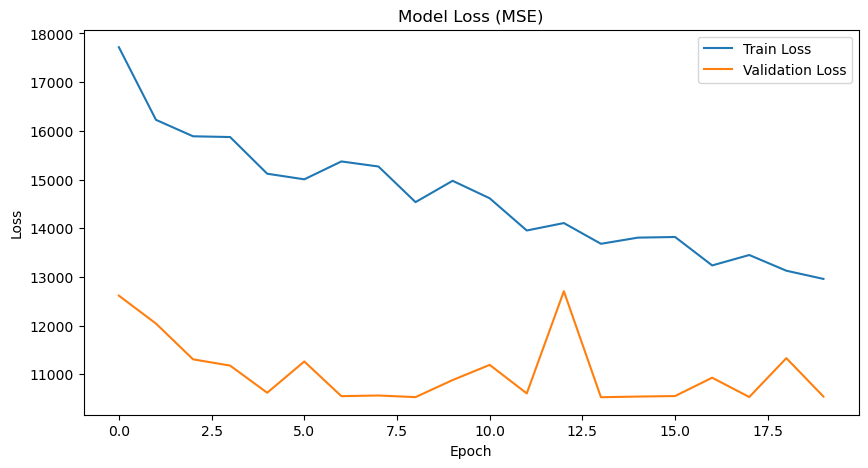

Model saved successfully.


In [3]:
def main():
    # Define the input and output directories
    input_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT'
    output_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation'
    
    # Define the required columns in the CSV files
    required_columns = {'Volume Index', 'Volume Start Time (s)', 'Label Time (s)', 'Orientation'}
    
    # Get the list of run prefixes
    prefixes = get_run_prefixes()
    
    # Load the data
    X, y = load_data(input_dir, output_dir, prefixes, required_columns)
    print(f"Total samples: {X.shape[0]}, Volume shape: {X.shape[1:]}, Labels shape: {y.shape}")
    
    # Split the data into training and testing sets
    test_size = 0.2
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
    print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")
    
    # Build the model
    input_shape = X_train.shape[1:]  # Should be (96, 96, 20, 1)
    model = build_model(input_shape)
    model.summary()
    
    # Compile the model
    learning_rate = 0.01
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # Create data generators
    batch_size = 5  # Adjust based on your system's memory capacity
    train_generator = DataGenerator(X_train, y_train, batch_size=batch_size, shuffle=True)
    test_generator = DataGenerator(X_test, y_test, batch_size=batch_size, shuffle=False)
    
    # Train the model
    epochs = 20  # Increase the number of epochs to overfit the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator,
    )
    
    # Evaluate the model
    test_loss, test_mae = model.evaluate(test_generator)
    print(f"Test Loss (MSE): {test_loss}")
    print(f"Test Mean Absolute Error: {test_mae}")
    
    # Plot training & validation loss values
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # Save the model
    model.save('orientation_prediction_cnn.h5')
    print("Model saved successfully.")

if __name__ == "__main__":
    main()
    

Loading saved test data...
Loaded X_test shape: (1277, 96, 96, 20, 1)
Loaded y_test shape: (1277,)
Trained model loaded successfully without compiling.
Model compiled successfully.
Generating predictions on the test set...
256/256 ━━━━━━━━━━━━━━━━━━━━ 45s 175ms/step
Predictions shape: (1277,)


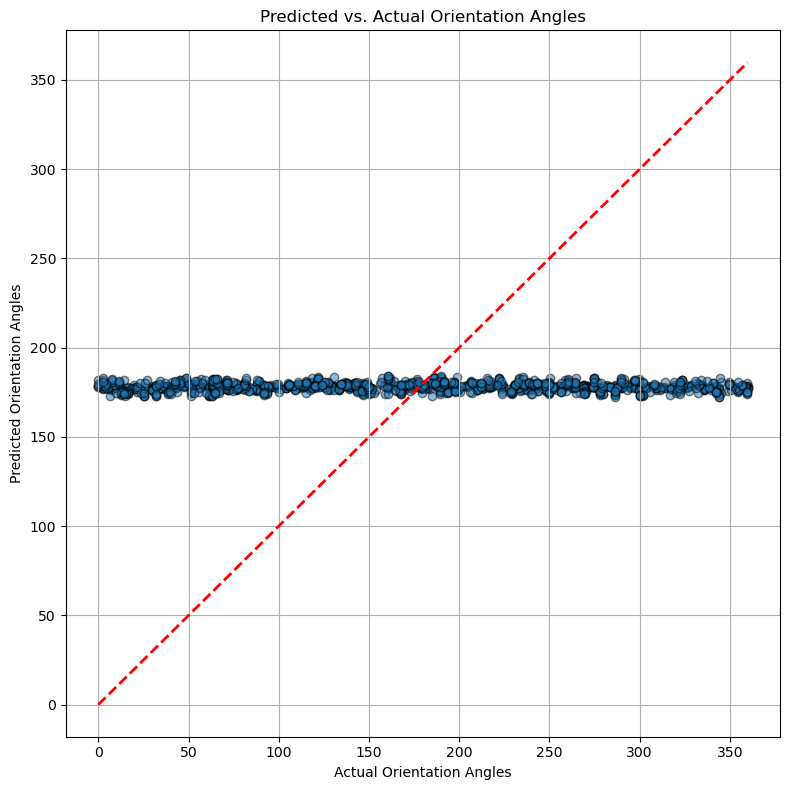

Predicted vs. Actual plot saved as 'predicted_vs_actual.png'.


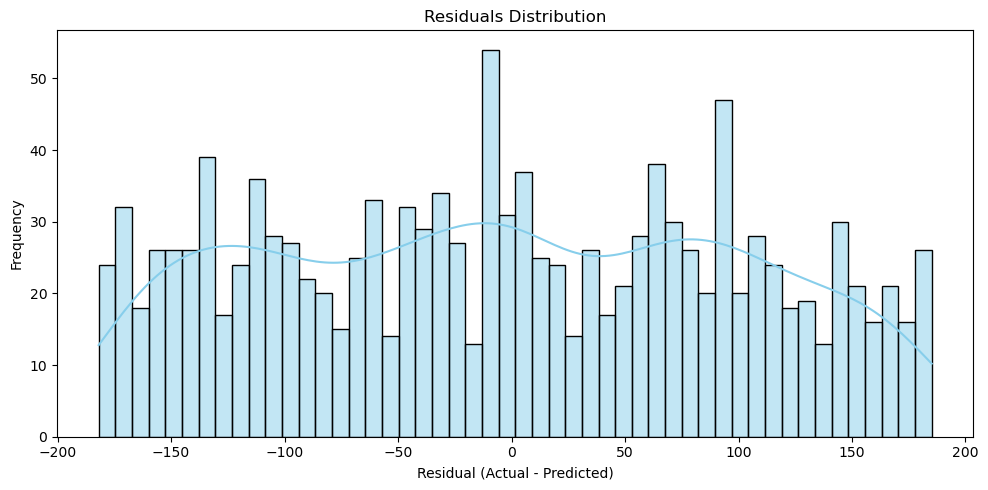

Residuals distribution plot saved as 'residuals_distribution.png'.
Mean Absolute Error (MAE): 87.70
Root Mean Squared Error (RMSE): 102.62
R-squared (R²): -0.00


/var/folders/tt/1l08355d2tb87jgn9r18nm4r0000gn/T/ipykernel_4638/295418373.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


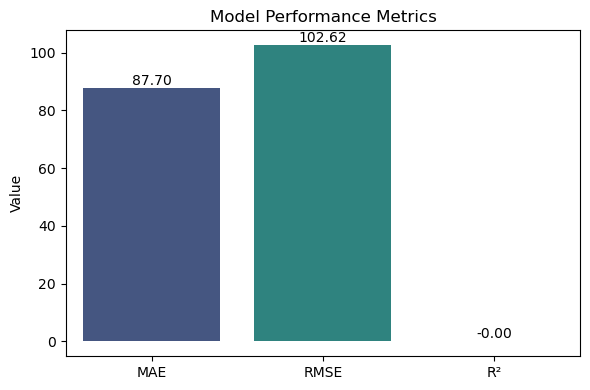

Error metrics bar plot saved as 'error_metrics.png'.


In [12]:
def get_run_prefixes():
    """Generate run prefixes for s05 and s14 runs."""
    s05 = [f"s05_run{str(i).zfill(3)}" for i in range(1, 13)]  # s05_run001 to s05_run012
    s14 = [f"s14_run{str(i).zfill(3)}" for i in range(2, 13)]  # s14_run002 to s14_run012
    return s05 + s14

def match_files(input_dir, output_dir, prefixes):
    """Match NIfTI files with their corresponding CSV label files."""
    matched = []
    for prefix in prefixes:
        nifti_path = os.path.join(input_dir, f"{prefix}.nii")
        csv_path = os.path.join(output_dir, f"{prefix}_orientations.csv")
        if os.path.isfile(nifti_path) and os.path.isfile(csv_path):
            matched.append((nifti_path, csv_path))
            print(f"Matched: {nifti_path} <--> {csv_path}")
        else:
            print(f"Warning: Missing file for prefix '{prefix}'")
    return matched

def load_data(input_dir, output_dir, prefixes, required_columns):
    """Load data and extract 3D volumes with corresponding labels."""
    X = []  # List to store 3D volumes
    y = []  # List to store orientation labels
    
    for nifti_path, csv_path in match_files(input_dir, output_dir, prefixes):
        try:
            # Load NIfTI data
            nii_img = nib.load(nifti_path)
            data = nii_img.get_fdata()
            print(f"Loaded NIfTI: {nifti_path} with shape {data.shape}")
            
            # Load CSV labels
            labels_df = pd.read_csv(csv_path)
            print(f"Loaded CSV: {csv_path} with {len(labels_df)} entries")
            
            # Validate CSV columns
            if not required_columns.issubset(labels_df.columns):
                print(f"Error: Missing columns in {csv_path}. Required columns: {required_columns}")
                continue
            
            # Validate volume count
            if data.shape[3] != len(labels_df):
                print(f"Error: Volume mismatch in {nifti_path} and {csv_path}")
                continue
            
            # Normalize the BOLD signals 
            data = (data - np.mean(data)) / np.std(data)
            
            # Extract individual volumes and their labels
            for i in range(data.shape[3]):
                volume = data[:, :, :, i]  # 3D volume at time point i
                volume = np.expand_dims(volume, axis=-1)  # Add channel dimension
                X.append(volume)
                y.append(labels_df['Orientation'].values[i])
            
            print(f"Successfully processed {nifti_path} and {csv_path}\n")
        except Exception as e:
            print(f"Error processing {nifti_path} and {csv_path}: {e}")
            continue
    
    X = np.array(X)  # Shape: (total_samples, x_dim, y_dim, z_dim, channels)
    y = np.array(y)  # Shape: (total_samples,)
    return X, y

def plot_predicted_vs_actual(y_test, predictions):
    """Plot Predicted vs. Actual Orientation Angles."""
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, predictions, alpha=0.5, edgecolors='k')
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('Actual Orientation Angles')
    plt.ylabel('Predicted Orientation Angles')
    plt.title('Predicted vs. Actual Orientation Angles')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('predicted_vs_actual.png')
    plt.show()
    print("Predicted vs. Actual plot saved as 'predicted_vs_actual.png'.")

def plot_residuals(y_test, predictions):
    """Plot the distribution of residuals."""
    residuals = y_test - predictions
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, bins=50, kde=True, color='skyblue')
    plt.title('Residuals Distribution')
    plt.xlabel('Residual (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('residuals_distribution.png')
    plt.show()
    print("Residuals distribution plot saved as 'residuals_distribution.png'.")

def plot_error_metrics(y_test, predictions):
    """Calculate and plot error metrics."""
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.2f}")

    # Bar plot for error metrics
    metrics = ['MAE', 'RMSE', 'R²']
    values = [mae, rmse, r2]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=metrics, y=values, palette='viridis')
    plt.title('Model Performance Metrics')
    plt.ylabel('Value')
    for index, value in enumerate(values):
        plt.text(index, value + 0.01 * max(values), f"{value:.2f}", ha='center')
    plt.tight_layout()
    plt.savefig('error_metrics.png')
    plt.show()
    print("Error metrics bar plot saved as 'error_metrics.png'.")

def main():
    # Paths to your data and model
    input_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT'
    output_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation'
    model_path = 'orientation_prediction_cnn.h5'  # Ensure this path is correct

    # Define the required columns in the CSV files
    required_columns = {'Volume Index', 'Volume Start Time (s)', 'Label Time (s)', 'Orientation'}

    # Check if test data is already saved
    test_data_path_X = 'X_test.npy'
    test_data_path_y = 'y_test.npy'
    if os.path.exists(test_data_path_X) and os.path.exists(test_data_path_y):
        print("Loading saved test data...")
        X_test = np.load(test_data_path_X)
        y_test = np.load(test_data_path_y)
        print(f"Loaded X_test shape: {X_test.shape}")
        print(f"Loaded y_test shape: {y_test.shape}")
    else:
        print("Saved test data not found. Loading and processing data...")
        prefixes = get_run_prefixes()
        X, y = load_data(input_dir, output_dir, prefixes, required_columns)
        print(f"Total samples: {X.shape[0]}, Volume shape: {X.shape[1:]}, Labels shape: {y.shape}")
        
        # Split the data into training and testing sets
        test_size = 0.2
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, shuffle=False
        )
        print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
        print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")
        
        # Save the test data for future use
        np.save(test_data_path_X, X_test)
        np.save(test_data_path_y, y_test)
        print("Test data saved successfully.")

    # Load the trained model without compiling
    if os.path.exists(model_path):
        model = load_model(model_path, compile=False)
        print("Trained model loaded successfully without compiling.")
    else:
        print(f"Error: Trained model file '{model_path}' not found.")
        return

    # Compile the model
    learning_rate = 0.01  
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    print("Model compiled successfully.")

    # Generate predictions
    print("Generating predictions on the test set...")
    predictions = model.predict(X_test, batch_size=5).flatten()
    print(f"Predictions shape: {predictions.shape}")

    # Plot Predicted vs. Actual
    plot_predicted_vs_actual(y_test, predictions)

    # Plot Residuals Distribution
    plot_residuals(y_test, predictions)

    # Plot Error Metrics
    plot_error_metrics(y_test, predictions)

if __name__ == "__main__":
    main()
